In [1]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ezc3d import c3d
from scipy.signal import resample
from scipy.io import loadmat, savemat
from joblib import load, dump
from tqdm import tqdm
from scipy.signal import butter, lfilter

In [2]:
PATH_DATASETS = '../../Dataset/'
PATH_DATASET_2 = 'gait-dbase-2/'

N_SAMPLES = 1024
FORCE_THRESHOLD = 20
TOE_HEIGTH_THRESHOLD = 40

In [3]:
class GrfFilter(object): 
    @staticmethod
    def butter_lowpass(cutoff, fs, order):
        nyq = 0.5 * fs
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return b, a

    def apply(data, cutoff=10, fs=2000, order=2):
        b, a = GrfFilter.butter_lowpass(cutoff, fs, order=order)
        y = lfilter(b, a, data)
        y = y - np.median(y)
        return y

In [56]:
def standardize(x):
    return (x - np.mean(x, axis=0)) / np.std(x, axis=0)

def require_positive(x):
    if x < 0:
        return 0
    else:
        return x

def clip_overflow(x, max=N_SAMPLES):
    if x >= max:
        return N_SAMPLES - 1
    else:
        return x

def clip_noise(x, min=FORCE_THRESHOLD):
    mask = x > min
    new_x = np.zeros(x.shape)
    new_x[mask] = x[mask]
    return new_x

def get_first_grf(x, swing_period):
    half_way = x.shape[0] / 2
    temp = np.zeros(x.shape)
    temp[:half_way] = x[:half_way]
    stance_mask = temp < FORCE_THRESHOLD
    stance_start = np.min(stance_mask == True)
    stance_end = np.max(stance_mask == True)
    roi_start = stance_start
    roi_end = stance_end + swing_period
    return temp[roi_start : roi_end]

def get_processed_grf(grf, clip=False):
    processed_grf = GrfFilter.apply(grf)
    if clip:
        processed_grf[processed_grf < FORCE_THRESHOLD] = 0
    return resample(processed_grf, N_SAMPLES * 4, axis=0).T
    

In [86]:
path = os.path.join(PATH_DATASETS, PATH_DATASET_2)
subjects = os.listdir(path)

features = pd.DataFrame()
target = pd.DataFrame()

records = []
n_samples = 0
n_bad_samples = 0

for subject in tqdm(subjects):
    velocities_path = os.path.join(path, subject, 'Raw_Data')
    velocities = os.listdir(velocities_path)

    for velocity in velocities:

        files_path = os.path.join(velocities_path, velocity)
        files = os.listdir(files_path)

        for filename in files:
            # try:
                content = c3d(os.path.join(files_path, filename), extract_forceplat_data=True)
            
                # trajectory_x_r = content['data']['points'][0, 6:11, :]
                # trajectory_y_r = content['data']['points'][1, 6:11, :]
                # trajectory_z_r = content['data']['points'][2, 6:11, :]

                # trajectory_x_l = content['data']['points'][0, 18:23, :]
                # trajectory_y_l = content['data']['points'][1, 18:23, :]
                # trajectory_z_l = content['data']['points'][2, 18:23, :]

                # trajectory_x_r = resample(trajectory_x_r, N_SAMPLES, axis=1).T
                # trajectory_y_r = resample(trajectory_y_r, N_SAMPLES, axis=1).T
                # trajectory_z_r = resample(trajectory_z_r, N_SAMPLES, axis=1).T

                # trajectory_x_l = resample(trajectory_x_l, N_SAMPLES, axis=1).T
                # trajectory_y_l = resample(trajectory_y_l, N_SAMPLES, axis=1).T
                # trajectory_z_l = resample(trajectory_z_l, N_SAMPLES, axis=1).T

                # ...................... Force X ...........................

                force_x_2 = content['data']['platform'][1]['force'][0, :]
                force_x_3 = content['data']['platform'][2]['force'][0, :]
                force_x_4 = content['data']['platform'][3]['force'][0, :]
                force_x_5 = content['data']['platform'][4]['force'][0, :]

                # .................... Fix sign of left foot .....................
                force_x_3 = -force_x_3
                force_x_5 = -force_x_5

                force_x_2 = get_processed_grf(force_x_2)
                force_x_3 = get_processed_grf(force_x_3)
                force_x_4 = get_processed_grf(force_x_4)
                force_x_5 = get_processed_grf(force_x_5)

                # ..................... Force Y ...........................

                force_y_2 = content['data']['platform'][1]['force'][1, :]
                force_y_3 = content['data']['platform'][2]['force'][1, :]
                force_y_4 = content['data']['platform'][3]['force'][1, :]
                force_y_5 = content['data']['platform'][4]['force'][1, :]

                force_y_2 = get_processed_grf(force_y_2)
                force_y_3 = get_processed_grf(force_y_3)
                force_y_4 = get_processed_grf(force_y_4)
                force_y_5 = get_processed_grf(force_y_5)

                # ....................... Force Z ............................

                force_z_2 = content['data']['platform'][1]['force'][2, :]
                force_z_3 = content['data']['platform'][2]['force'][2, :]
                force_z_4 = content['data']['platform'][3]['force'][2, :]
                force_z_5 = content['data']['platform'][4]['force'][2, :]

                force_z_2 = get_processed_grf(force_z_2, True)
                force_z_3 = get_processed_grf(force_z_3, True)
                force_z_4 = get_processed_grf(force_z_4, True)
                force_z_5 = get_processed_grf(force_z_5, True)


                # ... Remove all zero GRF samples
                if np.mean(force_z_2) <= FORCE_THRESHOLD or np.mean(force_z_3) <= FORCE_THRESHOLD \
                    or np.mean(force_z_4) <= FORCE_THRESHOLD or np.mean(force_z_5) <= FORCE_THRESHOLD:
                    n_bad_samples = n_bad_samples + 1
                    continue

                grf_combined_x_r = force_x_2 + force_x_4
                grf_combined_x_l = force_x_3 + force_x_5
                grf_combined_y_r = force_y_2 + force_y_4
                grf_combined_y_l = force_y_3 + force_y_5
                grf_combined_z_r = force_z_2 + force_z_4
                grf_combined_z_l = force_z_3 + force_z_5

                grf_mask_r = (grf_combined_z_r >= FORCE_THRESHOLD)
                grf_mask_l = (grf_combined_z_l >= FORCE_THRESHOLD)

                grf_start_r = np.min(np.argwhere(grf_mask_r == True))
                grf_end_r = np.max(np.argwhere(grf_mask_r == True))
                grf_start_l = np.min(np.argwhere(grf_mask_l == True))
                grf_end_l = np.max(np.argwhere(grf_mask_l == True))

                swing_period_r = np.sum(grf_combined_z_r[grf_start_r:grf_end_r] <= FORCE_THRESHOLD)
                swing_period_l = np.sum(grf_combined_z_l[grf_start_l:grf_end_l] <= FORCE_THRESHOLD)

                mask_force_x_r_1 = (force_x_2 > FORCE_THRESHOLD)
                mask_force_x_r_2 = (force_x_4 > FORCE_THRESHOLD)
                mask_force_x_l_1 = (force_x_3 > FORCE_THRESHOLD)
                mask_force_x_l_2 = (force_x_5 > FORCE_THRESHOLD)

                mask_force_y_r_1 = (force_y_2 > FORCE_THRESHOLD)
                mask_force_y_r_2 = (force_y_4 > FORCE_THRESHOLD)
                mask_force_y_l_1 = (force_y_3 > FORCE_THRESHOLD)
                mask_force_y_l_2 = (force_y_5 > FORCE_THRESHOLD)

                mask_force_z_r_1 = (force_z_2 > FORCE_THRESHOLD)
                mask_force_z_r_2 = (force_z_4 > FORCE_THRESHOLD)
                mask_force_z_l_1 = (force_z_3 > FORCE_THRESHOLD)
                mask_force_z_l_2 = (force_z_5 > FORCE_THRESHOLD)


                # ----------------------- RIGHT ----------------------

                start = np.min(np.argwhere(mask_force_z_r_1 == True))
                end = np.max(np.argwhere(mask_force_z_r_1 == True)) + swing_period_r

                force_x_r_1 = force_x_2[start : end]
                force_y_r_1 = force_y_2[start : end]
                force_z_r_1 = force_z_2[start : end]

                start = np.min(np.argwhere(mask_force_z_r_2 == True))
                end = np.max(np.argwhere(mask_force_z_r_2 == True)) + swing_period_r

                force_x_r_2 = force_x_4[start : end]
                force_y_r_2 = force_y_4[start : end]
                force_z_r_2 = force_z_4[start : end]

                # ----------------------- LEFT ----------------------

                start = np.min(np.argwhere(mask_force_z_l_1 == True))
                end = np.max(np.argwhere(mask_force_z_l_1 == True)) + swing_period_l

                force_x_l_1 = force_x_3[start : end]
                force_y_l_1 = force_y_3[start : end]
                force_z_l_1 = force_z_3[start : end]

                start = np.min(np.argwhere(mask_force_z_l_2 == True))
                end = np.max(np.argwhere(mask_force_z_l_2 == True)) + swing_period_l

                force_x_l_2 = force_x_5[start : end]
                force_y_l_2 = force_y_5[start : end]
                force_z_l_2 = force_z_5[start : end]

                # roi_start_r = require_positive(grf_start_r - swing_period_r)
                # roi_end_r = clip_overflow(grf_end_r + swing_period_r)

                # roi_start_l = require_positive(grf_start_l - swing_period_l)
                # roi_end_l = clip_overflow(grf_end_l + swing_period_l)

                # trajectory_x_r = trajectory_x_r[roi_start_l:roi_end_l]
                # trajectory_x_l = trajectory_x_l[roi_start_r:roi_end_r]
                # trajectory_y_r = trajectory_y_r[roi_start_l:roi_end_l]
                # trajectory_y_l = trajectory_y_l[roi_start_r:roi_end_r]
                # trajectory_z_r = trajectory_z_r[roi_start_l:roi_end_l]
                # trajectory_z_l = trajectory_z_l[roi_start_r:roi_end_r]

                # force_x_r = grf_combined_x_r[roi_start_r:roi_end_r]
                # force_x_l = grf_combined_x_l[roi_start_l:roi_end_l]
                # force_y_r = grf_combined_y_r[roi_start_r:roi_end_r]
                # force_y_l = grf_combined_y_l[roi_start_l:roi_end_l]
                # force_z_r = grf_combined_z_r[roi_start_r:roi_end_r]
                # force_z_l = grf_combined_z_l[roi_start_l:roi_end_l]

                # trajectory_x_r = resample(trajectory_x_r, N_SAMPLES, axis=0)
                # trajectory_x_l = resample(trajectory_x_l, N_SAMPLES, axis=0)
                # trajectory_y_r = resample(trajectory_y_r, N_SAMPLES, axis=0)
                # trajectory_y_l = resample(trajectory_y_l, N_SAMPLES, axis=0)
                # trajectory_z_r = resample(trajectory_z_r, N_SAMPLES, axis=0)
                # trajectory_z_l = resample(trajectory_z_l, N_SAMPLES, axis=0)

                # force_x_r = resample(force_x_r, N_SAMPLES, axis=0)
                # force_x_l = resample(force_x_l, N_SAMPLES, axis=0)
                # force_y_r = resample(force_y_r, N_SAMPLES, axis=0)
                # force_y_l = resample(force_y_l, N_SAMPLES, axis=0)
                # force_z_r = resample(force_z_r, N_SAMPLES, axis=0)
                # force_z_l = resample(force_z_l, N_SAMPLES, axis=0)

                force_x_r_1 = resample(force_x_r_1, N_SAMPLES, axis=0)
                force_x_l_1 = resample(force_x_l_1, N_SAMPLES, axis=0)
                force_x_r_2 = resample(force_x_r_2, N_SAMPLES, axis=0)
                force_x_l_2 = resample(force_x_l_2, N_SAMPLES, axis=0)

                force_y_r_1 = resample(force_y_r_1, N_SAMPLES, axis=0)
                force_y_l_1 = resample(force_y_l_1, N_SAMPLES, axis=0)
                force_y_r_2 = resample(force_y_r_2, N_SAMPLES, axis=0)
                force_y_l_2 = resample(force_y_l_2, N_SAMPLES, axis=0)

                force_z_r_1 = resample(force_z_r_1, N_SAMPLES, axis=0)
                force_z_l_1 = resample(force_z_l_1, N_SAMPLES, axis=0)
                force_z_r_2 = resample(force_z_r_2, N_SAMPLES, axis=0)
                force_z_l_2 = resample(force_z_l_2, N_SAMPLES, axis=0)


                # ... Standardize
                # trajectory_x_r = standardize(trajectory_x_r)
                # trajectory_x_l = standardize(trajectory_x_l)
                # trajectory_y_r = standardize(trajectory_y_r)
                # trajectory_y_l = standardize(trajectory_y_l)
                # trajectory_z_r = standardize(trajectory_z_r)
                # trajectory_z_l = standardize(trajectory_z_l)

                # force_x_r = standardize(force_x_r)
                # force_x_l = standardize(force_x_l)
                # force_y_r = standardize(force_y_r)
                # force_y_l = standardize(force_y_l)
                # force_z_r = standardize(force_z_r)
                # force_z_l = standardize(force_z_l)

                # _features_l = pd.DataFrame(
                #     np.concatenate([trajectory_x_l, trajectory_y_l, trajectory_z_l], axis=1),
                #     columns=[
                #         '7_x', '8_x', '9_x', '10_x', '11_x',
                #         '7_y', '8_y', '9_y', '10_y', '11_y',
                #         '7_z', '8_z', '9_z', '10_z', '11_z'
                #     ]
                # )

                # _features_r = pd.DataFrame(
                #     np.concatenate([trajectory_x_r, trajectory_y_r, trajectory_z_r], axis=1),
                #     columns=[
                #         '7_x', '8_x', '9_x', '10_x', '11_x',
                #         '7_y', '8_y', '9_y', '10_y', '11_y',
                #         '7_z', '8_z', '9_z', '10_z', '11_z'
                #     ]
                # )

                # _features = pd.concat([_features_l, _features_r], axis=0)

                _target_r_1 = pd.DataFrame(
                    np.stack([force_x_r_1, force_y_r_1, force_z_r_1], axis=1),
                    columns=['fx', 'fy', 'fz']
                )

                _target_r_2 = pd.DataFrame(
                    np.stack([force_x_r_2, force_y_r_2, force_z_r_2], axis=1),
                    columns=['fx', 'fy', 'fz']
                )

                _target_l_1 = pd.DataFrame(
                    np.stack([force_x_l_1, force_y_l_1, force_z_l_1], axis=1),
                    columns=['fx', 'fy', 'fz']
                )

                _target_l_2 = pd.DataFrame(
                    np.stack([force_x_l_2, force_y_l_2, force_z_l_2], axis=1),
                    columns=['fx', 'fy', 'fz']
                )

                _target = pd.concat([_target_r_1, _target_r_2, _target_l_1, _target_l_2], axis=0)

                # features = pd.concat([features, _features], axis=0, ignore_index=True)
                target = pd.concat([target, _target], axis=0, ignore_index=True)

                records.append(filename)

                n_samples = n_samples + 1

            # except Exception as e:
            #     print(f'ERROR [{subject}/{velocity}/{filename}]: {e}')
            #     n_bad_samples = n_bad_samples + 1
            #     pass
            # break
        break
    break

print('Number of good samples: ', n_samples)
print('Number of bad samples: ', n_bad_samples)

  0%|          | 0/16 [00:10<?, ?it/s]

Number of good samples:  10
Number of bad samples:  0


In [84]:
grf_start_r

722

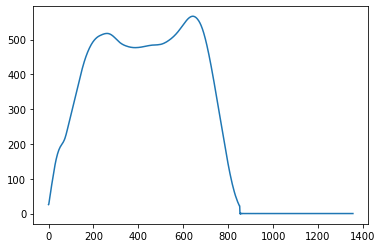

In [85]:
plt.plot(force_z_r_1)

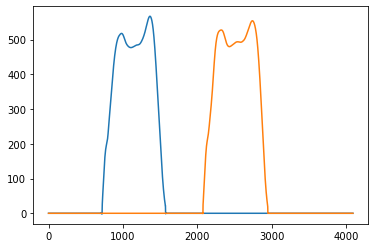

In [80]:
plt.plot(force_z_2)
plt.plot(force_z_4)

In [8]:
features

,7_x,8_x,9_x,10_x,11_x,7_y,8_y,9_y,10_y,11_y,7_z,8_z,9_z,10_z,11_z
0,0.525651,0.522405,0.498826,0.641698,0.615675,-1.504327,-1.440021,-1.439210,-1.395655,-1.398567,-0.507495,-0.780480,-0.830014,-0.816721,-0.713094
1,0.661515,0.656541,0.630743,0.803473,0.771981,-1.684362,-1.612322,-1.611542,-1.564359,-1.567870,-0.491793,-0.830439,-0.878123,-0.831218,-0.723652
2,0.376186,0.372299,0.353259,0.475552,0.450689,-1.274310,-1.220498,-1.220060,-1.180708,-1.182908,-0.526388,-0.726886,-0.770529,-0.771093,-0.689505
3,0.606480,0.609722,0.578394,0.757877,0.726485,-1.645242,-1.575919,-1.575121,-1.528841,-1.532266,-0.512380,-0.818485,-0.860888,-0.834853,-0.728221
4,0.436273,0.467512,0.440226,0.595456,0.565483,-1.428638,-1.367589,-1.366992,-1.324788,-1.327650,-0.522338,-0.766661,-0.805312,-0.798131,-0.707299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20475,1.456519,1.236936,1.189035,0.937947,0.660011,1.588889,1.501613,1.494762,1.437967,1.389784,-0.879298,-0.200628,-0.043689,-0.816496,-0.396110
20476,1.601527,1.358753,1.321286,1.066694,0.768783,1.990474,1.894640,1.888354,1.816701,1.757346,-0.898464,-0.128585,-0.004067,-0.766495,-0.333006
20477,1.304626,1.121811,1.096049,0.878562,0.658518,1.163950,1.090602,1.084985,1.044235,1.009349,-0.809791,-0.278973,-0.126033,-0.809512,-0.438320
20478,1.563336,1.281222,1.224803,0.905391,0.561224,2.002464,1.895548,1.887946,1.806263,1.740325,-1.090352,-0.224450,-0.069068,-0.855576,-0.324224


In [7]:
target

,fx,fy,fz
0,0.863244,0.055511,-0.948637
1,0.863799,0.053706,-0.948305
2,0.872782,0.052119,-0.947595
3,0.871075,0.050444,-0.947984
4,0.876305,0.048470,-0.947460
...,...,...,...
2007035,0.824179,0.021090,-0.976676
2007036,0.838015,0.021205,-0.977637
2007037,0.847455,0.020994,-0.978282
2007038,0.802710,0.019769,-0.974661


In [8]:
path = '../../Dataset/Processed/data2.joblib'
data = {
    'X': features,
    'y': target
}
# dump(data, path)

['../../Dataset/Processed/data2.joblib']

<h1 align="center">Verification</h1>

In [9]:
path = '../../Dataset/Processed/data2.joblib'
data = load(path)

features = data['X']
target = data['y']

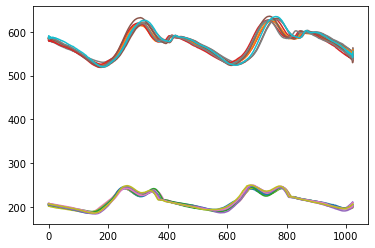

In [23]:
x = features['7_z'].to_numpy().reshape(-1, N_SAMPLES)
for i in range(x.shape[0]):
    plt.plot(x[i, :])

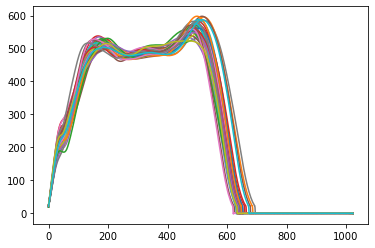

In [87]:
y = target['fz'].to_numpy().reshape(-1, N_SAMPLES)
for i in range(y.shape[0]):
    plt.plot(y[i, :])

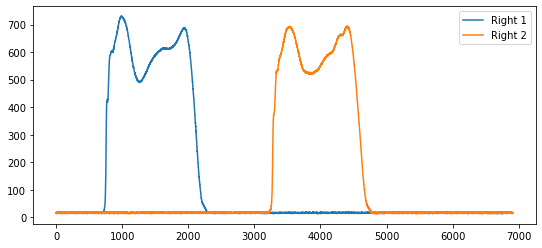

In [12]:
path = '../../Dataset/gait-dbase-2/Participant14/Raw_Data/V35/T4.c3d'
content = c3d(path, extract_forceplat_data=True)
force_z_1 = content['data']['platform'][0]['force'][2, :]
force_z_2 = content['data']['platform'][1]['force'][2, :]
force_z_3 = content['data']['platform'][2]['force'][2, :]
force_z_4 = content['data']['platform'][3]['force'][2, :]
force_z_5 = content['data']['platform'][4]['force'][2, :]
force_z_6 = content['data']['platform'][5]['force'][2, :]
# trajectory_z_l = content['data']['points'][2, 9:15, :]
# trajectory_z_r = content['data']['points'][2, 20:26, :]
trajectory_z_r = content['data']['points'][2, 6:11, :]
trajectory_z_l = content['data']['points'][2, 18:23, :]

# clean_grf = GrfFilter.apply(force_z_2)
plt.figure(figsize=(9, 4))
# plt.plot(force_z_1, label='Force plate 1')
plt.plot(force_z_2, label='Right 1')
# plt.plot(force_z_3, label='Left 1')
plt.plot(force_z_4, label='Right 2')
# plt.plot(force_z_5, label='Left 2')
# plt.plot(force_z_6, label='Force plate 6')
# plt.plot(trajectory_z_l.T)

plt.legend()

In [37]:
z = np.zeros((3, 1))
len(z)

3

In [39]:
force_x_4.shape

(1024,)